### plotting with seaborn
only use under analysis environment 

Basically everthing that needed to read/modify/write excel and plotting with sns

June update:
added section for generating excel files for averaged brains based on individual sample's excel

In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd

import re

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

# use seaborn for easier logrithmic color scale

import itertools
# use itertool to flatten list of list

In [2]:
def find_mousename(text):
    #finds name of mouse that follows the typical LSENS pattern: two letters followed by 3 numbers, ie AL000
    a= re.search('[a-zA-Z]{2}[0-9]{2,3}', text)
    return a[0]

def prep_df(df):
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    #new= read_file.set_index('id').sort_values(by='graph_order').T
    #This lines sorts the region ids according to its graph order, such that related regions are ordered together 
    # ie, barrel field layers are grouped together
    # Note that this order would be disrupted when you have to later concatenate dfs with different columns...so need to rearrange later
    
    
    new= read_file.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df(folder,list_of_fname,inner=False):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_name_initial=os.path.join(folder, list_of_fname[0])
    full_df=prep_df(full_name_initial)
    
    if inner==True:
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1, join='inner')

    else: 
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1)

    full_df=full_df.T.iloc[1:]
    return full_df


def prep_df_specific(df,region_id=''):
    '''Look for regions belong to one of the group by specifying region_id = : 
    343 brainstem
    567 cerebrum
    leave empty for everything else
    ie prep_df_specific(path_to_df) gives regions not belonging to brainstem or cerebrum
    prep_df_specific(path_to_df, region_id =343) gives regions belonging to brainstem only
    '''
    
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    #new= read_file.set_index('id').sort_values(by='graph_order').T
    #This lines sorts the region ids according to its graph order, such that related regions are ordered together 
    # ie, barrel field layers are grouped together
    # Note that this order would be disrupted when you have to later concatenate dfs with different columns...so need to rearrange later
    
    if region_id:
        specific_df=read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    else:
        searchfor = ['/343/','/567/']
        specific_df= read_file.loc[~read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]            
    
    new= specific_df.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df_specific(folder,list_of_fname,region_id=''):
    
    '''    # combine multiple data frames, keeping only mouse name, region id and amount of voxels
    by default, returns all of the regions that at least one brain that projects to it
    region_id specifies to look for brain regions only belonging to brainstem(343), cerebrum(567) or all others('')'''

    #initialize a list for data frames to combine
    df_list = []
    for i in parent_axons:
        this_df = prep_df_specific(os.path.join(folder, i),region_id=region_id).T
        df_list.append(this_df)
    full_df = pd.concat(df_list)

    return full_df

# def combine_df_specific_new(folder,list_of_fname,region_id='', inner=False):
    
#     ''' !! Use this one becase combine_df_specific does not work in some cases which I havn't figured out why... 
#     combine multiple data frames, keeping only mouse name, region id and amount of voxels
#     by default, returns all of the regions that at least one brain that projects to it
#     region_id specifies to look for brain regions only belonging to brainstem(343), cerebrum(567) or all others('')'''
    
#     full_df=pd.DataFrame(columns=['acronym'])
#     for i in list_of_fname:
#         this_df = prep_df_specific(os.path.join(folder, i),region_id=region_id)
#         full_df=pd.merge(full_df,this_df,on='acronym', how='outer')
#     return full_df.set_index('acronym')

### Generate excel files for averaged brains based on excel file of each sample
with standard deviations

In [4]:
folder= r'D:\viral_results\s1'
outdir = r'D:\viral_results\s1_results'

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

In [5]:
def average_excel(name_list, side, output_name):
    parent_axons= [ i for i  in os.listdir(folder) if f'{side}_region' in i]
    #change side to right for the other hemisphere!
    
    file_list=[]
    for i in name_list:
        contained = [x for x in parent_axons if i in x]
        file_list.append(contained[0])
    # extract all the file containing thesample name
    
    print('now processing the following files:')
    print(f'{file_list}')
    
    out_name=os.path.join(outdir,output_name)
    
    axonal_df= combine_df(folder, file_list)
    axonal_df=axonal_df.T
    
    y=axonal_df.index.to_list()
    test_order=[]

    for i in y:
        name=atlas_labels.query(f"acronym== '{i}'").graph_order.values[0]
        test_order.append(name)

    sort_acronym_df= pd.DataFrame({'acronyms':y, 'graph_order': test_order})
    sort_acronym_df.sort_values('graph_order', inplace=True)
    # sort the aconnyms based on graph order

    final_df= axonal_df.reindex(sort_acronym_df.acronyms.to_list())
    #final_df
    
    final_df['average']=final_df.mean(axis=1)
    final_df['std']= final_df.std(axis=1)
    # compute average and std
    
    result = pd.merge(final_df.reset_index(), atlas_labels, on=['acronym'])
    # need to reset_index here because acronym was both an index and a column
    
    result.to_excel(f'{out_name}_avg_{side}.xlsx') 
    
    return 


#### for s1 sim1 samples

In [29]:
region='s1'
mouse_line= 'sim'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'
name_list= ['AL207','AL209','AL273']

##### left side - detialed code

In [24]:
side='left'
parent_axons= [ i for i  in os.listdir(folder) if f'{side}_region' in i]
#change side to right for the other hemisphere!

#name_list= ['AL207','AL209','AL273']

file_list=[]
for i in name_list:
    contained = [x for x in parent_axons if i in x]
    file_list.append(contained[0])
# extract all the file containing thesample name

file_list

out_name=os.path.join(outdir,'s1_sim')

In [8]:
axonal_df= combine_df(folder, file_list)
axonal_df=axonal_df.T

axonal_df.head()

# combine values from relevant samples based on acronym

,AL207,AL209,AL273
acronym,,,
fiber tracts,0.005841,0.001936,0.00355
RT,0.019293,0.00478,0.005749
VISal1,0.001994,0.000344,0.000134
ll,0.000155,0.000083,0.000156
MD,0.000292,0.00026,0.000875


In [9]:
y=axonal_df.index.to_list()
test_order=[]

for i in y:
    name=atlas_labels.query(f"acronym== '{i}'").graph_order.values[0]
    test_order.append(name)
    
sort_acronym_df= pd.DataFrame({'acronyms':y, 'graph_order': test_order})
sort_acronym_df.sort_values('graph_order', inplace=True)
# sort the aconnyms based on graph order

final_df= axonal_df.reindex(sort_acronym_df.acronyms.to_list())
#final_df

In [15]:
final_df['average']=final_df.mean(axis=1)
final_df['std']= final_df.std(axis=1)
# compute average and std

In [18]:
result = pd.merge(final_df.reset_index(), atlas_labels, on=['acronym'])
# need to reset_index here because acronym was both an index and a column
result.head()

# final result keeps all individual values but also computed average and std

,acronym,AL207,AL209,AL273,average,std,id,atlas_id,name,st_level,...,graph_order,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name
0,root,0.000642,0.000836,0.003453,0.001644,0.001282,997,-1.0,root,0,...,0,/997/,FFFFFF,NaN,NaN,f,1,385153371,734881840,root
1,FRP2/3,NaN,NaN,0.000004,0.000004,0.000000,667,1073.0,"Frontal pole, layer 2/3",11,...,8,/997/8/567/688/695/315/184/667/,268F45,NaN,NaN,f,9,4268100038,734881840,Frontal pole layer 2/3
2,FRP5,NaN,NaN,0.000075,0.000075,0.000000,526157192,NaN,"Frontal pole, layer 5",11,...,9,/997/8/567/688/695/315/184/526157192/,268F45,NaN,NaN,f,10,1413248090,734881840,Frontal pole layer 5
3,MOp1,0.000872,0.000001,0.001212,0.000695,0.000510,320,888.0,"Primary motor area, Layer 1",11,...,19,/997/8/567/688/695/315/500/985/320/,1F9D5A,NaN,NaN,f,20,571569106,734881840,Primary motor area Layer 1
4,MOp2/3,0.002361,0.000201,0.002009,0.001524,0.000946,943,966.0,"Primary motor area, Layer 2/3",11,...,20,/997/8/567/688/695/315/500/985/943/,1F9D5A,NaN,NaN,f,21,2488357079,734881840,Primary motor area Layer 2/3


In [19]:
result.to_excel(f'{out_name}_avg_{side}.xlsx') 
# save

##### right side 

In [38]:
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL207_axon_right_region_with_counts.xlsx', 'AL209_axon_right_region_with_counts.xlsx', 'AL273_axon_right_region_with_counts.xlsx']


#### for s2 sim1 samples

In [14]:
region='s2'
mouse_line= 'sim'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL281','AL286','AL321','AL322']

In [15]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL281_axon_left_region_with_counts.xlsx', 'AL286_axon_left_region_with_counts.xlsx', 'AL321_axon_left_region_with_counts.xlsx', 'AL322_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL281_axon_right_region_with_counts.xlsx', 'AL286_axon_right_region_with_counts.xlsx', 'AL321_axon_right_region_with_counts.xlsx', 'AL322_axon_right_region_with_counts.xlsx']


#### for s1 rbp samples

In [16]:
region='s1'
mouse_line= 'rbp'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'


name_list= ['AL211','AL215','AL318']


In [17]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL211_axon_left_region_with_counts.xlsx', 'AL215_axon_left_region_with_counts.xlsx', 'AL318_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL211_axon_right_region_with_counts.xlsx', 'AL215_axon_right_region_with_counts.xlsx', 'AL318_axon_right_region_with_counts.xlsx']


#### for s2 rbp samples

In [18]:
region='s2'
mouse_line= 'rbp'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'


name_list= ['AL288','AL326','AL327']

In [19]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL288_axon_left_region_with_counts.xlsx', 'AL326_axon_left_region_with_counts.xlsx', 'AL327_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL288_axon_right_region_with_counts.xlsx', 'AL326_axon_right_region_with_counts.xlsx', 'AL327_axon_right_region_with_counts.xlsx']


#### for s1 tlx samples

In [20]:
region='s1'
mouse_line= 'tlx'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL213','AL313','AL314']

In [21]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL213_axon_left_region_with_counts.xlsx', 'AL313_axon_left_region_with_counts.xlsx', 'AL314_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL213_axon_right_region_with_counts.xlsx', 'AL313_axon_right_region_with_counts.xlsx', 'AL314_axon_right_region_with_counts.xlsx']


#### for s2 tlx samples

In [22]:
region='s2'
mouse_line= 'tlx'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'
name_list= ['AL278','AL280','AL319']

In [23]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL278_axon_left_region_with_counts.xlsx', 'AL280_axon_left_region_with_counts.xlsx', 'AL319_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL278_axon_right_region_with_counts.xlsx', 'AL280_axon_right_region_with_counts.xlsx', 'AL319_axon_right_region_with_counts.xlsx']


#### for s1 ras samples

In [24]:
region='s1'
mouse_line= 'ras'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL254','AL255','AL257']

In [25]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL254_axon_left_region_with_counts.xlsx', 'AL255_axon_left_region_with_counts.xlsx', 'AL257_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL254_axon_right_region_with_counts.xlsx', 'AL255_axon_right_region_with_counts.xlsx', 'AL257_axon_right_region_with_counts.xlsx']


#### for s2 ras samples

In [26]:
region='s2'
mouse_line= 'ras'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL303','AL332','AL333']

In [27]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL303_axon_left_region_with_counts.xlsx', 'AL332_axon_left_region_with_counts.xlsx', 'AL333_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL303_axon_right_region_with_counts.xlsx', 'AL332_axon_right_region_with_counts.xlsx', 'AL333_axon_right_region_with_counts.xlsx']


#### for s1 scn samples

In [28]:
region='s1'
mouse_line= 'scn'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL290','AL291','AL292','AL293']

In [29]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL290_axon_left_region_with_counts.xlsx', 'AL291_axon_left_region_with_counts.xlsx', 'AL292_axon_left_region_with_counts.xlsx', 'AL293_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL290_axon_right_region_with_counts.xlsx', 'AL291_axon_right_region_with_counts.xlsx', 'AL292_axon_right_region_with_counts.xlsx', 'AL293_axon_right_region_with_counts.xlsx']


#### for s2 scn samples

In [30]:
region='s2'
mouse_line= 'scn'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'
name_list= ['AL290','AL292','AL323']


In [31]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL290_axon_left_region_with_counts.xlsx', 'AL292_axon_left_region_with_counts.xlsx', 'AL323_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL290_axon_right_region_with_counts.xlsx', 'AL292_axon_right_region_with_counts.xlsx', 'AL323_axon_right_region_with_counts.xlsx']


#### for s1 nts samples

In [32]:
region='s1'
mouse_line= 'nts'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL274','AL285','AL311']

In [33]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL274_axon_left_region_with_counts.xlsx', 'AL285_axon_left_region_with_counts.xlsx', 'AL311_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL274_axon_right_region_with_counts.xlsx', 'AL285_axon_right_region_with_counts.xlsx', 'AL311_axon_right_region_with_counts.xlsx']


#### for s2 nts samples

In [34]:
region='s2'
mouse_line= 'nts'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'


name_list= ['AL274','AL310','AL330']


In [35]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL274_axon_left_region_with_counts.xlsx', 'AL310_axon_left_region_with_counts.xlsx', 'AL330_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL274_axon_right_region_with_counts.xlsx', 'AL310_axon_right_region_with_counts.xlsx', 'AL330_axon_right_region_with_counts.xlsx']


### log scale heatmap for axons in brain region

In [20]:
#find all relevant files
folder= r'D:\viral_results\s1'
outdir = r'D:\viral_results\s1_results'

files= [ i for i  in os.listdir(folder) if 'with_counts' in i]


In [29]:
side='left'
parent_axons= [ i for i  in os.listdir(folder) if 'Lparent' in i]
#change side to right and Rparent for the other hemisphere!

In [5]:
#parent_axons

In [30]:
axonal_df= combine_df(folder, parent_axons)
axonal_df=axonal_df.T


In [31]:
axonal_df.columns

Index(['AL207', 'AL209', 'AL211', 'AL213', 'AL215', 'AL254', 'AL255', 'AL257',
       'AL273', 'AL274', 'AL285', 'AL290', 'AL291', 'AL292', 'AL293', 'AL311',
       'AL313', 'AL314', 'AL318'],
      dtype='object')

In [32]:
column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314',
               'AL211', 'AL215','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
# for verified s1 injections as of april .2023

#column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327',
#              'AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
#for s2 injections as of June.2023

final=axonal_df[column_order]
df=final.fillna(0.00000000001)
#fill Nan with a very small number since the sns heat map do not accept nan

In [33]:
y=final.index.to_list()
test_order=[]

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

for i in y:
    name=atlas_labels.query(f"acronym== '{i}'").graph_order.values[0]
    test_order.append(name)

# get all the acronyms involved and their graphorder

In [34]:
sort_acronym_df= pd.DataFrame({'acronyms':y, 'graph_order': test_order})
sort_acronym_df.sort_values('graph_order', inplace=True)
# sort the aconnyms based on parent structure id

In [35]:
final_df= df.reindex(sort_acronym_df.acronyms.to_list())
#final_df

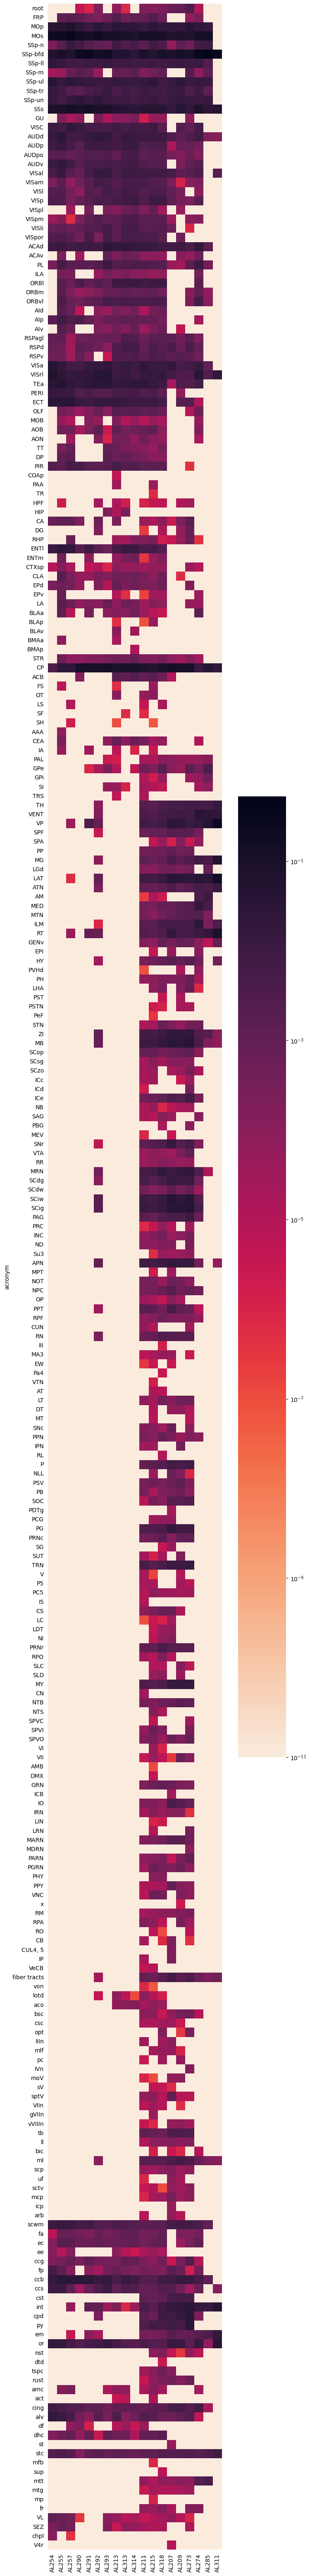

In [36]:
fig, ax = plt.subplots(figsize=(10,80))
g1= sns.heatmap(final_df, norm=LogNorm(), cmap="rocket_r", square=True,linewidths=0.0, rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!


plt.savefig(f'{outdir}\{side}_heatmap_logscale.svg')
plt.show()

### plotting correlation matrix with sns

In [3]:
indir= r'D:\viral_results\s1'
outdir = r'D:\viral_results\s1_results'

In [4]:
column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314',
               'AL211', 'AL215','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
# for verified s1 injections as of april .2023

#column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327',
#             'AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
#for s2 injections as of june.2023

In [5]:
axons_L= [ i for i  in os.listdir(indir) if 'axon_left' in i]
axonal_df_L= combine_df(indir, axons_L)
axonal_df_L.fillna(0, inplace=True)

axonal_df_L=axonal_df_L.T

axonal_df_L_ordered=axonal_df_L[column_order]
#order



In [6]:
axons_R= [ i for i  in os.listdir(indir) if 'axon_right' in i]
axonal_df_R= combine_df(indir, axons_R)
axonal_df_R.fillna(0, inplace=True)

axonal_df_R=axonal_df_R.T

axonal_df_R_ordered=axonal_df_R[column_order]
#order

#axonal_df_R_ordered['AL310'][0]=0.00000
# No need to do this if plotting the full correlation (both hemispheres), only do this for plotting right hemisphere correlaiton
# because some brains(such as AL285) have nothing at all in the right hemisphere, correlation will show up as NAN and hence a blank row/column in heatmap
# just assign 1 to a random item so this does not happen

In [7]:
right_acronym= [i+'_right' for i in axonal_df_R.index]
axonal_df_R['acronym']=right_acronym

axonal_df_R.set_index('acronym', inplace=True)
#Rename everything on the right side to preserve some spatial info

In [8]:
full_df=pd.concat([axonal_df_L,axonal_df_R])
full_df=full_df[column_order]
#full_df

In [9]:
full_corr=full_df.corr()


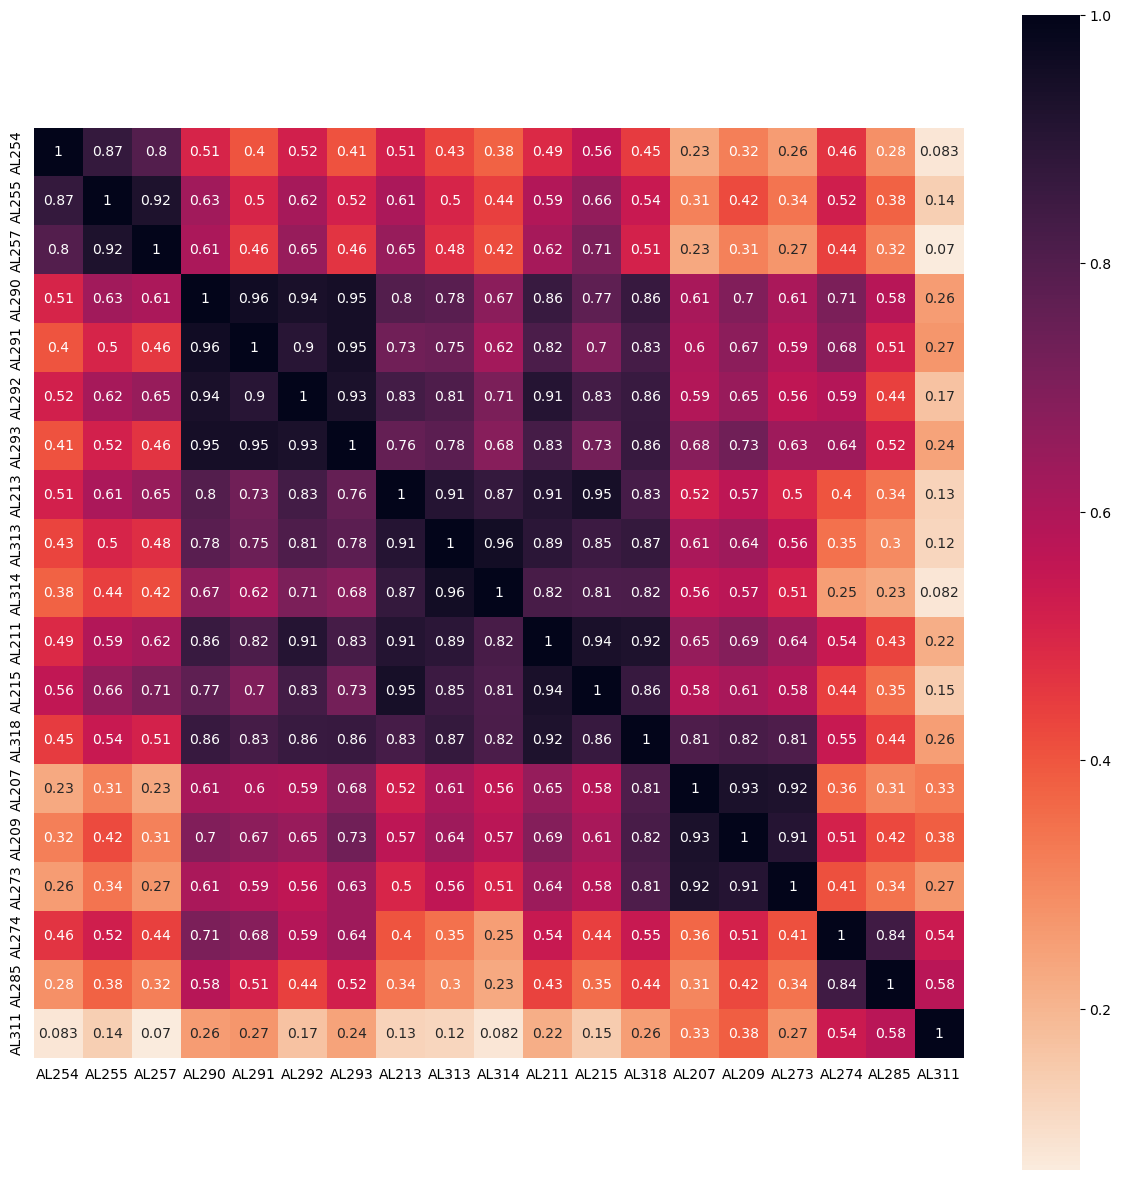

In [10]:

fig, ax = plt.subplots(figsize=(15,15))
g1=sns.heatmap(full_corr,  cmap="rocket_r", annot=True, square=True,linewidths=0.0, rasterized=True)
# set line width=0 and rasterized= true because when importing svg in illustrator, random whitelines are showing!

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\full_correlation.svg')
plt.show()

### section to plot bar graphs- a given region for a single injection site

deprecated

In [3]:
outdir= r'D:\\viral_results\\s1_s2'

In [4]:
region='s2'
mouseline='ras'
side='left'

file_path= f'D:\\viral_results\\{region}_results\\{region}_{mouseline}_avg_{side}.xlsx'
read_file= pd.read_excel(file_path)


some ids to consider

isocortex 315

    somatomotor areas 500
    somatosensory areas 453
    Temporal association area 541
    perirhinal area 922
    ectorhinal area 895
    ..and others


In [5]:
# get regions belonging to isocortex only
region_id='500'
choosen_regions= read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]


In [6]:
choosen_regions= choosen_regions.sort_values('graph_order', ascending=True)
# sort based on the graph order so more related regions are together

In [240]:
# this cell plots bar and point plot only,the benefit is each point from the same sample have a designated color

# sns.set(font_scale=2)

# fig, ax = plt.subplots(figsize=(40,20))
# g1=sns.barplot(data=choosen_regions, y="acronym", x="average",palette="hls", orient="h", zorder=0)

# g1.tick_params(bottom=False, left=False)
# # disable ticks because it is such a mess in illustrator!

# plt.rcParams['svg.fonttype'] = 'none'
# # so text stay as text not paths!

# sns.pointplot(data=choosen_regions, y="acronym", x="AL303", join=False, color='red', ax=ax)
# sns.pointplot(data=choosen_regions, y="acronym", x="AL332", join=False, color='green', ax=ax)
# sns.pointplot(data=choosen_regions, y="acronym", x="AL333", join=False, color='blue', ax=ax)

# plt.show()

### section to plot bar graphs- a given region for s1 vs s2 comparison

some ids to consider

isocortex 315

    Frontal pole 184
    somatomotor areas 500
    somatosensory areas 453
    gustatory area 1057
    visceral area 677
    auditory areas 247
    visual areas 669
    anterior cingulate area 31
    prelimbic area 972
    infralimbic area 44
    orbital area 714
    agranular insula 95
    retrosplenial area 254
    posterior association areas 22
    Temporal association area 541
    perirhinal area 922
    ectorhinal area 895

In [2]:
def extract_df(name_list,choosen_df, site):
    '''from data frame, extract only relevant information-> region acronyms and values from individual samples 
    then, insert injection site information (site = 's1' , or 's2')'''
    name_list.insert(0,'acronym')
    # insert acronym to the list to be used as extracting columns from df
    testdf=choosen_df[name_list]
    new=testdf.T
    #new

    new.columns =new.iloc[0]
    new=new.drop(new.index[0])
    # make the acronym row as column names, then drop the first row

    new['site']=site
    # add respective injection site info to each sample
    return new

def combine_expanddf (df1,df2):
    ''' combine two df , and prepare to sns barplot compatible format by pd.melt '''
    
    both_df= pd.concat([s1_df, s2_df])
    both_df=both_df.reset_index()
    
    site_column= both_df.pop('site')
    both_df.insert(1, "site", site_column, allow_duplicates=False)
    # some times the site column will not always be in the last position of column order after pd.concat, because some regions are not present in both averaged excel files
    # relocate the site column as the second in the column order(position 1) so in the next melt step we do not include it
    
    expand1=pd.melt(both_df, id_vars=['index'], value_vars=both_df.columns[2:])
    # melt into sns preferred format
    to_repeat=len(both_df.columns)-2
    # need to repeat injection site list for x times, minus the index column and the site column

    repeated_list=[]
    x=0
    while x<to_repeat:
        repeated_list.append(both_df['site'].to_list())
        x+=1
    
    new_list = itertools.chain(*repeated_list)
    new_list=list(new_list)
    len(new_list)
    # use itertool to flatten list of list, final length = number of sample * number of brain region

    expand1['site']= new_list
    # finally add the injection site information as a column
    
    return expand1


def grouped_bar(expanded_df):
    
    '''plot grouped bar plot + strip plot(for individual data points to show up on bar)
    for s1 vs s2 
    input: data frame with columns= index (sample identifier), acronym of region, value of axons, injection site for this sample. 
    Usually this data frame is the output of expand_df 
    '''

    sns.set(font_scale=2)

    fig, ax = plt.subplots(figsize=(20,80))

    # Draw the bar chart
    g1 = sns.barplot(
        data=expanded_df,
        x='value',
        y='acronym',
        hue='site',
        palette="hls",
        orient="h", 
        zorder=0,
        alpha=0.7, 
        errorbar=None,
    )

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!

    # Get the legend from just the bar chart
    handles, labels = g1.get_legend_handles_labels()

    # Draw the stripplot
    g2=sns.stripplot(
        data=expanded_df, 
        x='value',
        y='acronym',
        hue='site',
        palette="hls",
        orient="h", 
        size= 7,
        dodge=True, 
        jitter=False,
        edgecolor="black", 
        linewidth=.75,
        ax=ax,
    )

    # Remove the old legend
    g2.legend_.remove()
    # Add just the bar chart legend back
    ax.legend(
        handles,
        labels,
        loc='center right',
        bbox_to_anchor=(1, 0.9),
    )

    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!

    plt.savefig(f'{outdir}\\{mouseline}_avg_{side}_{region_id}.svg')

    plt.show()

In [9]:
outdir= r'D:\\viral_results\\s1_s2'

mouseline='nts'
# could be ras, scn, tlx, sim, rbp, or nts
side='right'
# could be left or right

# read in the two data frames. these xlsx files are output of the section above 'Generate excel files for averaged brains based on excel file of each sample'
region='s1'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{mouseline}_avg_{side}.xlsx'
read_file= pd.read_excel(file_path)
#read_file['injection']=region

region2='s2'
file_path2= f'D:\\viral_results\\{region2}_results\\{region2}_{mouseline}_avg_{side}.xlsx'
read_file2= pd.read_excel(file_path2)
#read_file2['injection']=region2


#ras list

s1_list=['AL254', 'AL255','AL257']
s2_list= ['AL303', 'AL332','AL333']


#scn list

s1_list=['AL290','AL291','AL292','AL293']
s2_list= ['AL290','AL292','AL323']

#tlx list
s1_list=['AL213','AL313','AL314']
s2_list= ['AL278','AL280','AL319']

#sim list

s1_list=['AL207','AL209','AL273']
s2_list=['AL281','AL286','AL321','AL322']

#rbp list

s1_list= ['AL211','AL215','AL318']
s2_list= ['AL288','AL326','AL327']

#nts list

s1_list= ['AL274','AL285','AL311']
s2_list= ['AL274','AL310','AL330']

In [10]:
# how about only keeping the relevant info and re arrange data frame
region_id='315'
choosen_regions= read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]

choosen_regions= choosen_regions.sort_values('graph_order', ascending=True)
# sort based on the graph order so more related regions are together

# repeat the same for s2
choosen_regions2= read_file2.loc[read_file2['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
choosen_regions2= choosen_regions2.sort_values('graph_order', ascending=True)


In [11]:
s1_df= extract_df(s1_list, choosen_regions,'s1')
s2_df= extract_df(s2_list, choosen_regions2,'s2')


In [12]:
expanded= combine_expanddf(s1_df,s2_df)

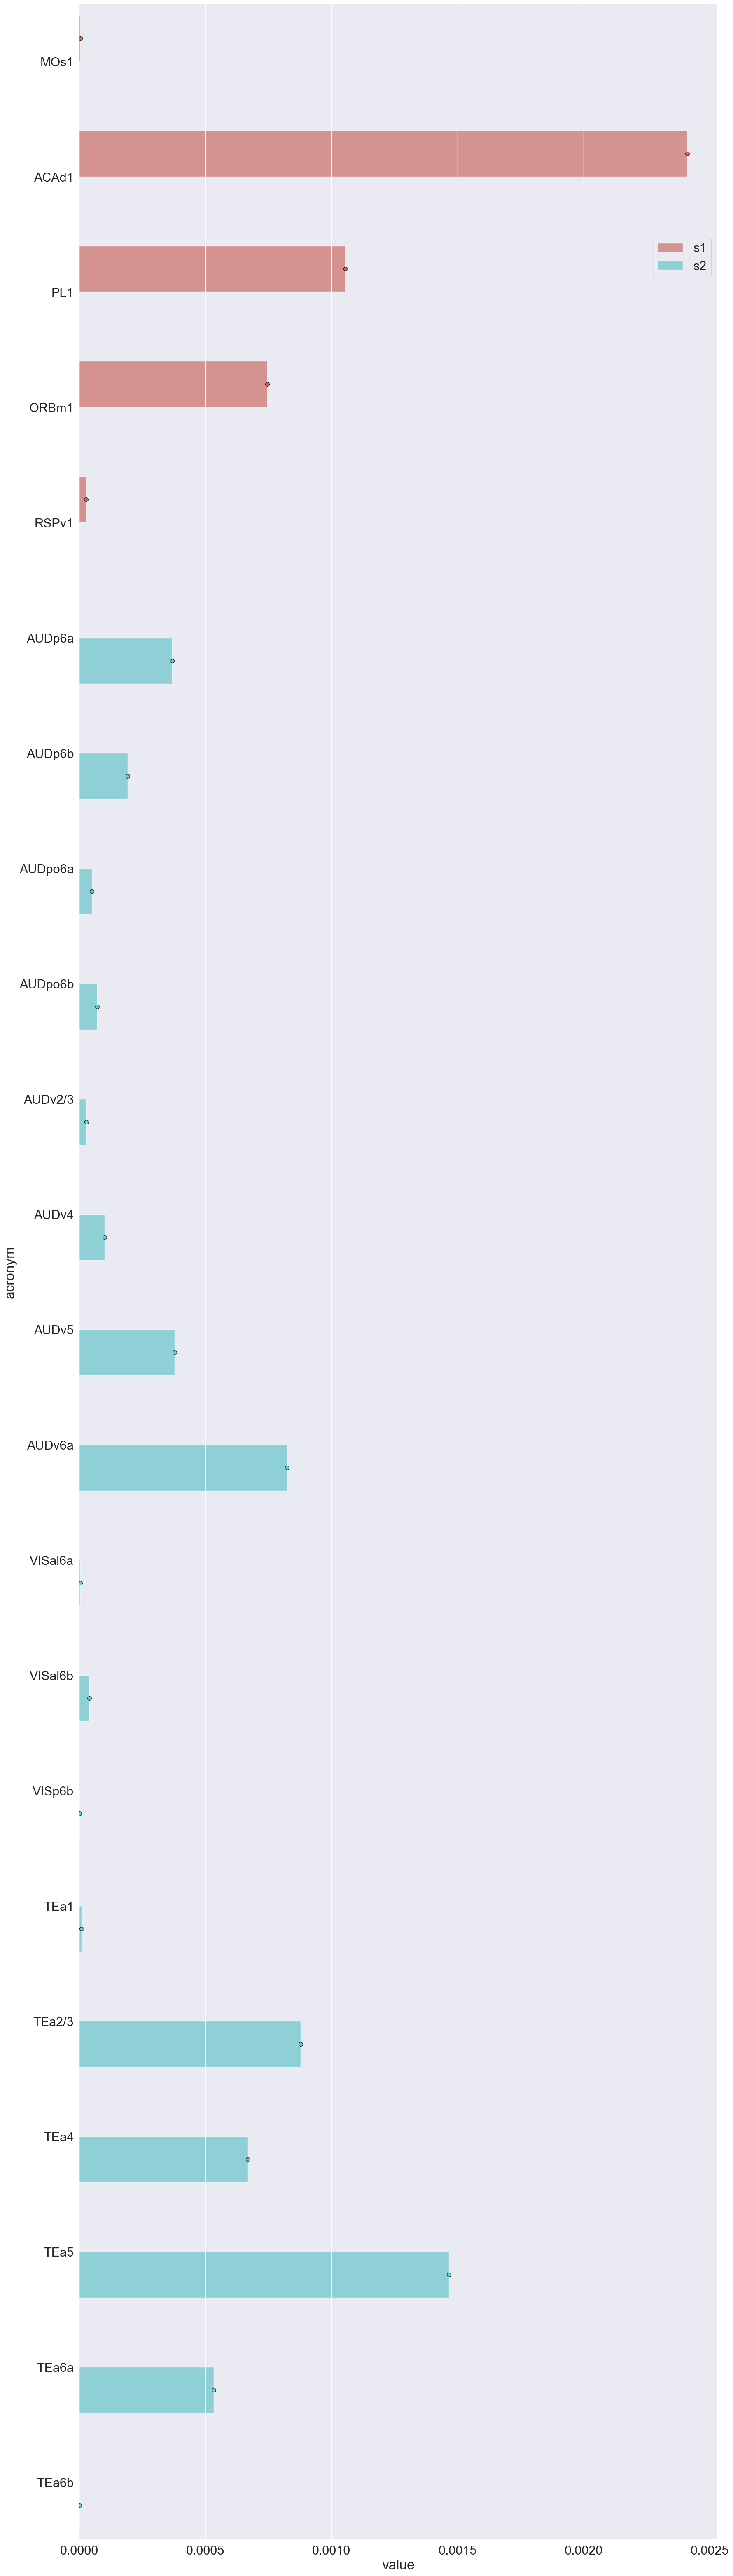

In [13]:
grouped_bar(expanded)

### test region

### section to plot bar graphs- a givne region for one injection site for all lines

In [84]:
WORK IN PROGRESS

outdir= r'D:\\viral_results\\s1_s2'

injsite='s1'
side='left'

# read in the two data frames
region='s1'
file_path= f'D:\\viral_results\\s1_s2\\{region}_{mouseline}_avg_{side}_region_with_counts.xlsx'
read_file= pd.read_excel(file_path)
read_file['injection']=region

region2='s2'
file_path2= f'D:\\viral_results\\s1_s2\\{region2}_{mouseline}_avg_{side}_region_with_counts.xlsx'
read_file2= pd.read_excel(file_path2)
read_file2['injection']=region2


### test section for hierarchical clustering

In [31]:
#final_df=final_df.rename(columns={'AL254': "ras1", 'AL255': "ras2", 'AL257': "ras3",
                         'AL290': "scn1", 'AL291': "scn2", 'AL292': "scn3",'AL293': "scn4",
                         'AL213': "tlx1", 'AL313': "tlx2", 'AL314': "tlx3",
                         'AL211': "rbp1", 'AL215': "rbp1", 'AL318': "rbp1",
                         'AL207': "sim1", 'AL209': "sim2", 'AL273': "sim3",
                         'AL274': "nts1", 'AL285': "nts2", 'AL311': "nts3",
                        })

#rearrange columns for sns.clustermap since it always wants to arrange columns in a weird way


C:\Users\liu\AppData\Local\Continuum\anaconda3\envs\analysis\lib\site-packages\seaborn\matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


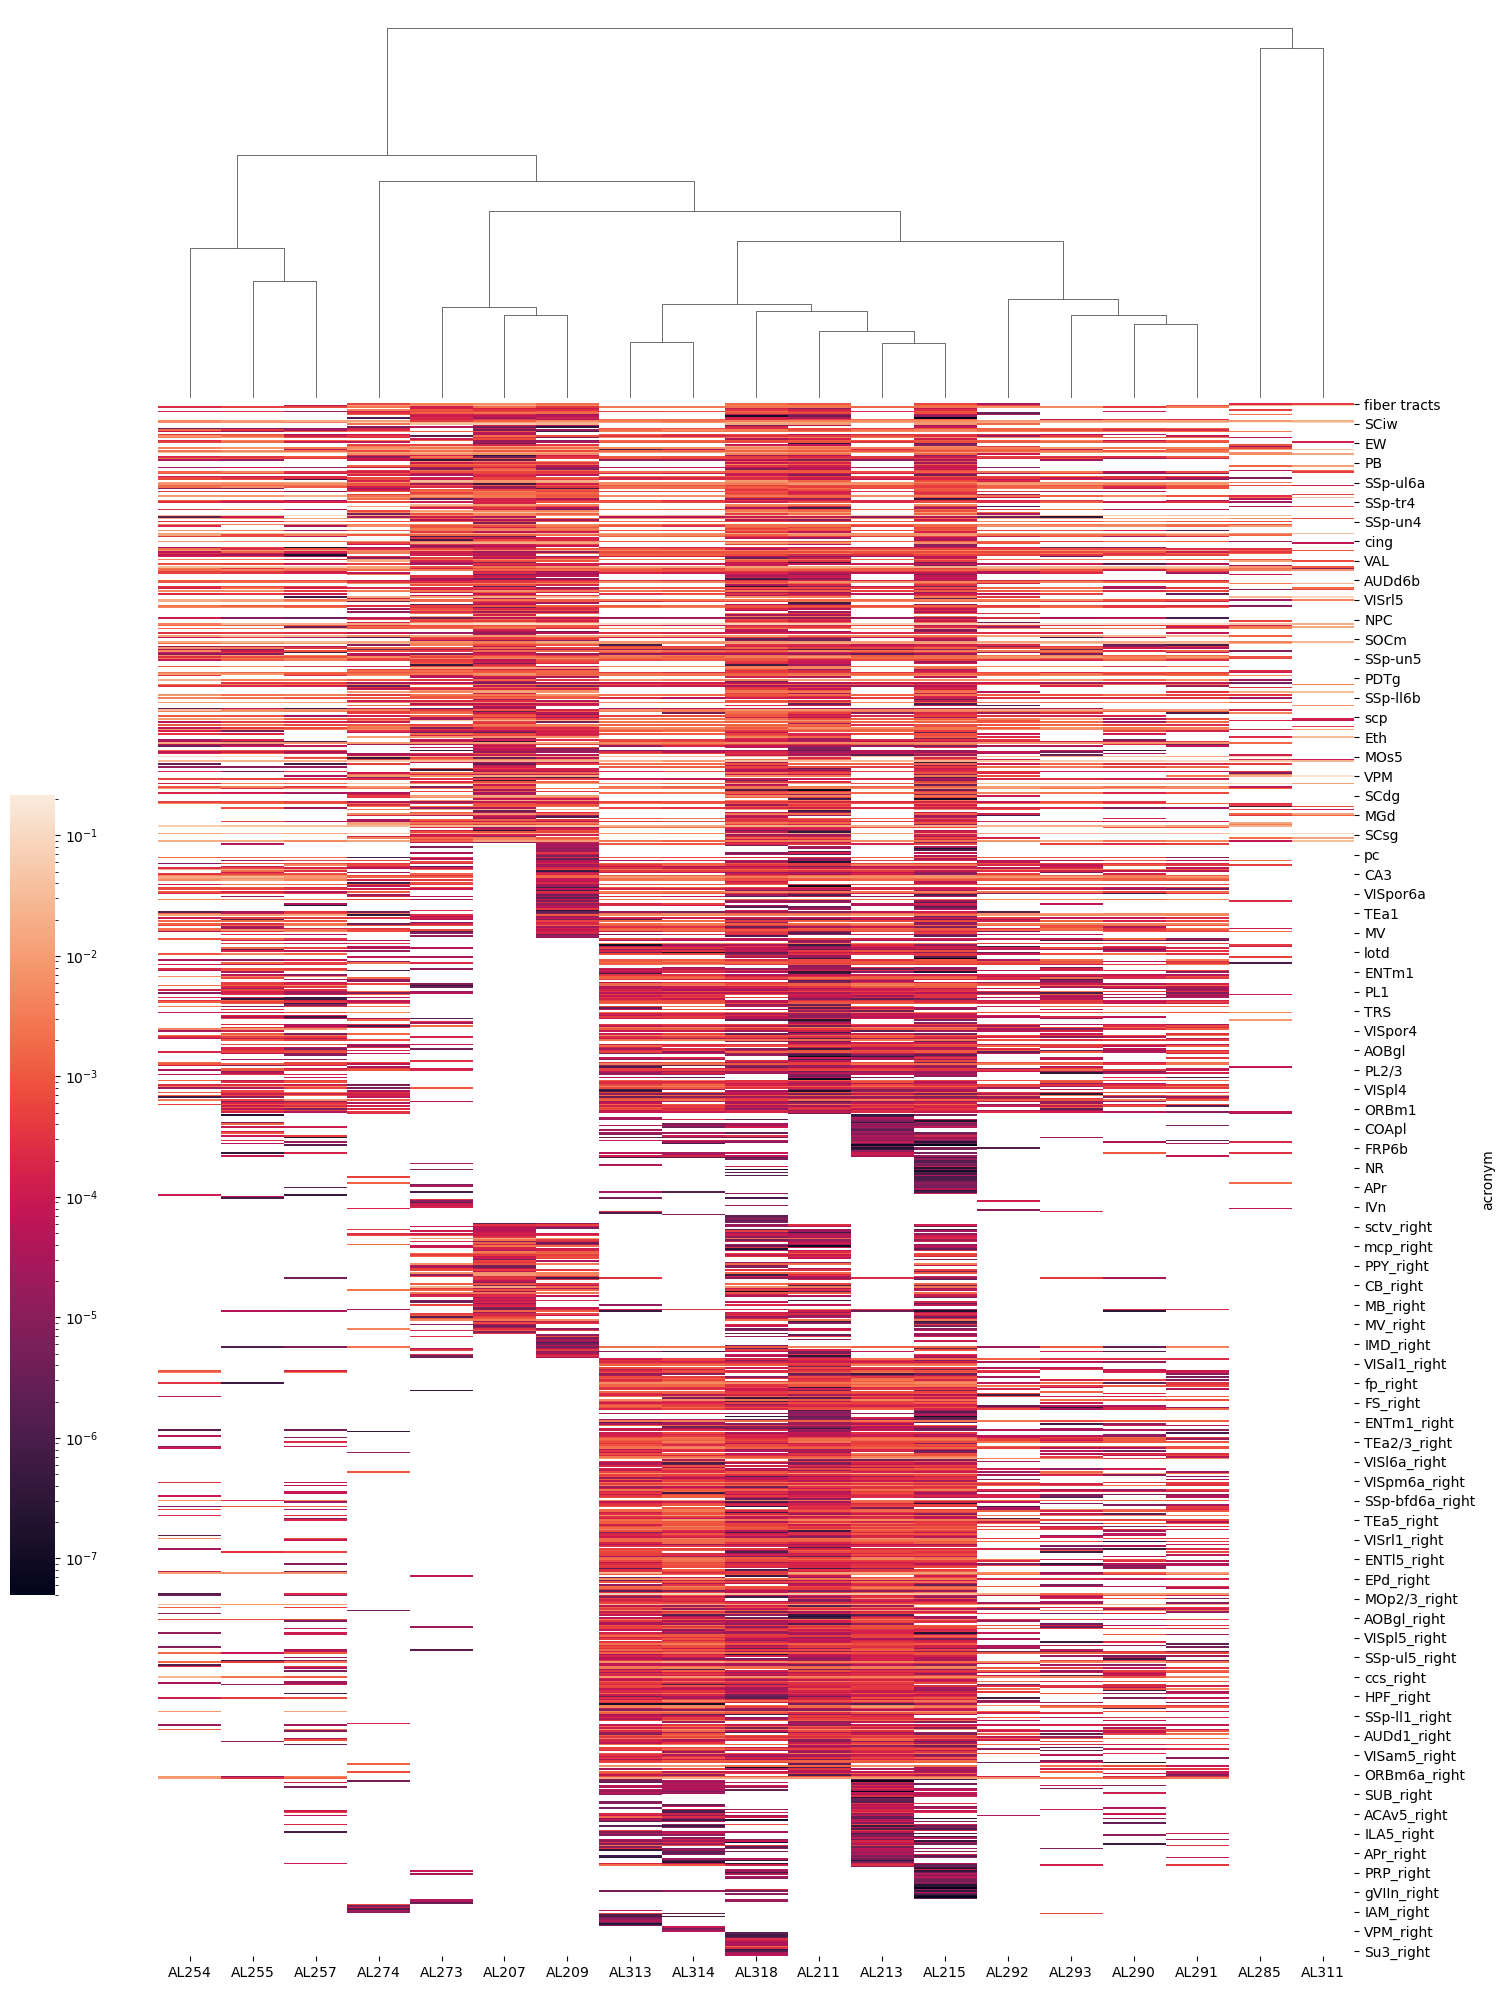

In [12]:
sns.clustermap(
    full_df,
    figsize=(15, 20),
    norm=LogNorm(),
    row_cluster=False,
    dendrogram_ratio=(.1, .2),
    cbar_pos=(0, .2, .03, .4)
)

WORK IN PROGRESS
# still in a weird way after rearrangement,...need to look up